<a href="https://colab.research.google.com/github/andrequant/Warwick/blob/main/u5586161_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ES98A - Fundamentals of Predictive Modelling
## Assignment 2
### Andre Lorenzo Bittencourt i
### u5586161


For this assignment, use the following test densities $\rho$.

- n=1. $\rho(x) \propto exp(-(x^2 -1)^2)$
- n = 2. $\rho((x_1, x_2)) \propto exp(-((x_1 - 1)^2 + 50(x_2 -x_1^2)^2))$

And

- $f(x) = cos(\|x\|)$
- $Q(f) = \int_{\mathbb{R}^n} f(x) \rho(x) dx$

To keep this assignment organized, all questions will be answered for the first distribution and then will be repeated for the second distribution.

As the distribution are not normalized, it is an open question if they should be or not. Even the GTA were unsure. So I let a Global Variable to control this.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.integrate import fixed_quad, nquad, dblquad

In [2]:
### Choose if densities will normalized (True) or not (False)

Normalized = True

## N = 1

#### $\rho(x) \propto exp(-1(x^2 -1)^2)$

### Exercise 2.1

In [3]:
### Define our basic functions

def rho_one(x): # Density for n=1
  def rho(x):
    return np.exp(-(x*x - 1)**2)
  if Normalized:
    return rho(x)/fixed_quad(rho,-5,5, n=100)[0]
  else:
    return rho(x)

def func1(x): # f
  return np.cos(np.abs(x))

def dQ1(x): # A bit of abuse of notation. f(x)rho(x).
  return func1(x)*rho_one(x)

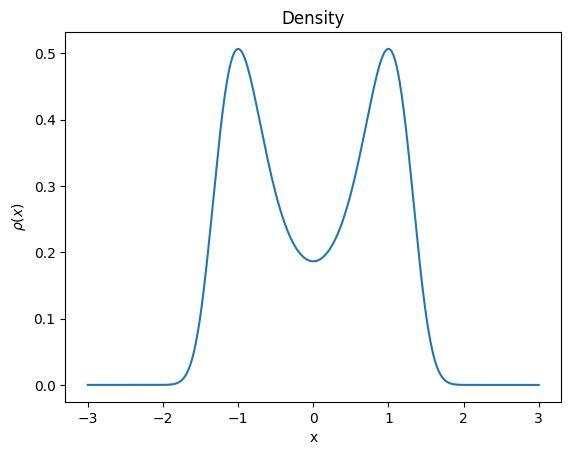

In [4]:
### Plot the density \rho(x1)

x = np.linspace(-3,3, 1000)

rho = rho_one(x)

plt.plot(x, rho)

plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.title('Density')


plt.show()

In [5]:
### Behaviour of off-the-shelf quadrature w.r.t N

N = np.linspace(1,50,50)
results = []


for n in N:
  results += scipy.integrate.fixed_quad(dQ1,-5,5, n=n)[0],

errors = [np.abs(results[int(i-1)]-results[-1]) for i in N[:-1]]
ln_errors = [np.log(error) for error in errors]

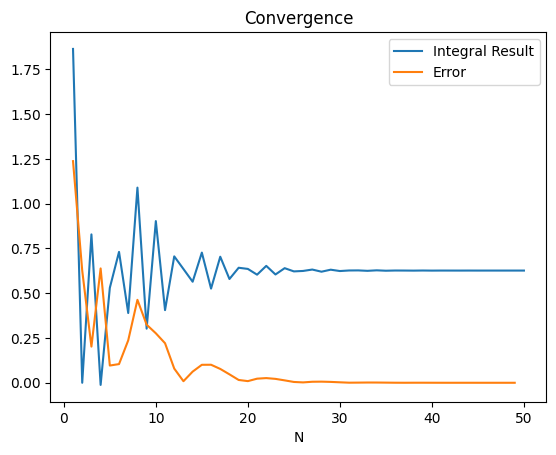

Integral result: 0.6264356546173949
Last error: 2.2844699682722514e-05


In [6]:
plt.plot(N, results, label='Integral Result')
plt.plot(N[:-1], errors, label='Error')
plt.legend()

plt.xlabel('N')
plt.title('Convergence')

plt.show()

print(f'Integral result: {results[-1]}')
print(f'Last error: {errors[-1]}')

The off-the-shelf routine, fixed_quad, seems to have converged for n>30. The computational time is also barely noticible.

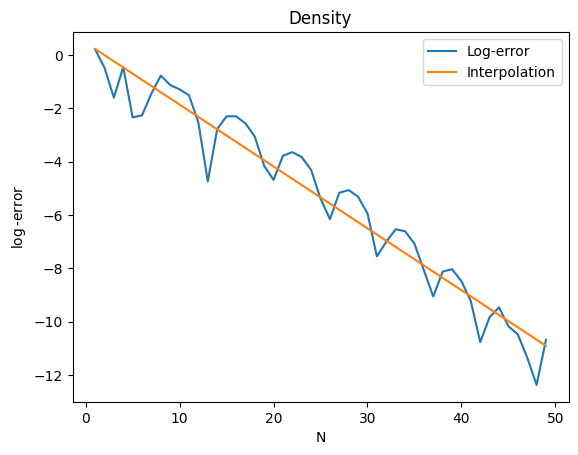

The approximate α is 0.23219232530001405


In [7]:
### The logarithm of the error

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(N[:-1].reshape((-1, 1)), ln_errors)
approx_error = model.intercept_ + N[:-1] * model.coef_

plt.plot(N[:-1], ln_errors, label='Log-error')
plt.plot(N[:-1], approx_error, label='Interpolation')

plt.legend()
plt.xlabel('N')
plt.ylabel(r'$\log$-error')
plt.title('Density')

plt.show()

alpha = '\\alpha'
print(f'The approximate α is {-model.coef_[0]}')

The convergence rate clearly appears to follow a patter $\propto N^{-\alpha}$, it $\alpha$ around 0.23. It also appears to have an cyclical patter. Perhaps, there is an advantage of using an N multiple of some number.

### Exercise 2.2

In [8]:
def mcmc_grw_one(density_func, n_variates, variance, step):

  x_j = 0
  total_variates = 0
  variates = []
  normals = np.random.normal(0,1, 100*n_variates)
  uniforms = np.random.uniform(0,1, 100*n_variates)
  ln_uniforms = np.log(uniforms)
  std = step*np.sqrt(variance)
  i = 0

  # Implementing the theoretical definition
  #def alpha_func(x,x_, density_func):
  #  return min(1, (density_func(x_)*scipy.stats.norm.pdf(x_,x,std))/(density_func(x)*scipy.stats.norm.pdf(x,x_,std)))

  # Implementing using log for computational reasons
  def alpha_func(x,x_, density_func):
    return min(0, (np.log(density_func(x_)) + np.log(scipy.stats.norm.pdf(x_,x,std))) - (np.log(density_func(x))+np.log(scipy.stats.norm.pdf(x,x_,std))))

  while total_variates < n_variates:

    x_k = normals[i]*std + x_j
    alpha = alpha_func(x_j, x_k, density_func)


    #if uniforms[i] <= alpha:
    if ln_uniforms[i] <= alpha:
      variates += x_k,
      x_j = x_k
    else:
      variates += x_j,

    total_variates +=1

    i += 1

  return variates

In [9]:
### Generate a sample
rnd = mcmc_grw_one(rho_one, 30000, 1, 1)

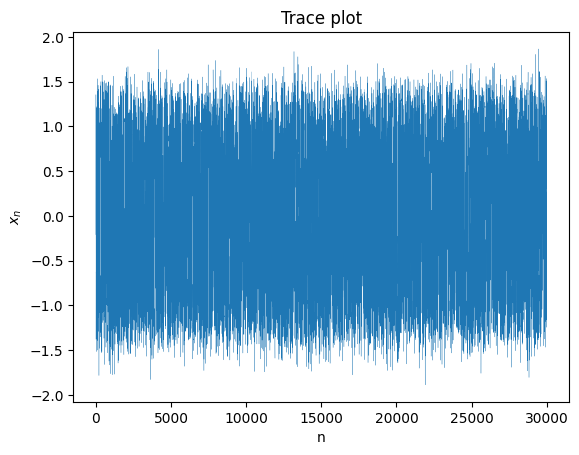

In [10]:
plt.plot(rnd,linewidth=.2)

plt.xlabel('n')
plt.ylabel(r'$x_n$')
plt.title('Trace plot')

plt.show()

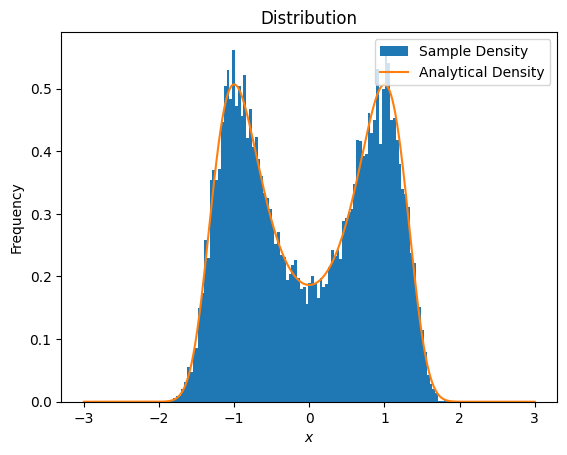

In [11]:
x = np.linspace(-3,3, 1000)
rho = rho_one(x)

plt.hist(rnd, density=True, bins=100, label='Sample Density')
plt.plot(x, rho, label='Analytical Density')
plt.title('Distribution')
plt.xlabel(r'$x$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [12]:
### Compute the quadrature error

En_f = []
En_f += 0,
f_avg = []



for i in range(len(rnd)):
  f = func1(rnd[i])
  if i == 0:
    f_avg += f,
  else:
    f_avg += ((i/(i+1)) * f_avg[-1] + (1/(i+1))*f),

En_f += np.abs(f_avg[:-2] - f_avg[-1]),

En_f = En_f[1:][0]

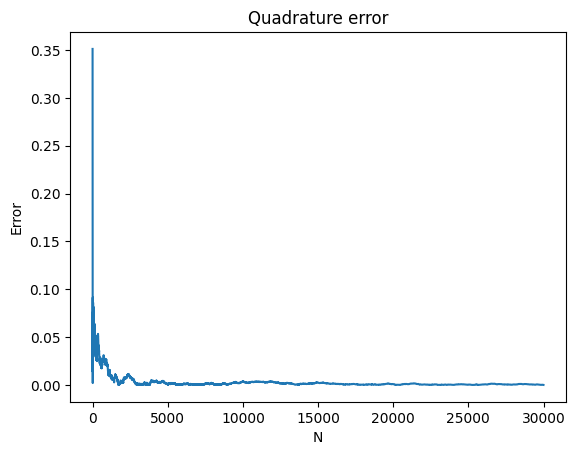

Last error: 1.1538464446236851e-05
Q_N(f): 0.6266950720633556


In [13]:
plt.title('Quadrature error')
plt.xlabel('N')
plt.ylabel('Error')
plt.plot(En_f)
plt.show()
print(f'Last error: {En_f[-1]}')
print(f'Q_N(f): {f_avg[-1]}')

Analyzing the quadrature error

In [14]:
### Estimating the error decay as in 2.1

model = LinearRegression().fit(np.linspace(1,len(En_f),len(En_f)).reshape((-1, 1)), np.log(En_f))
approx_error = model.intercept_ + np.linspace(1,len(En_f),len(En_f)) * model.coef_

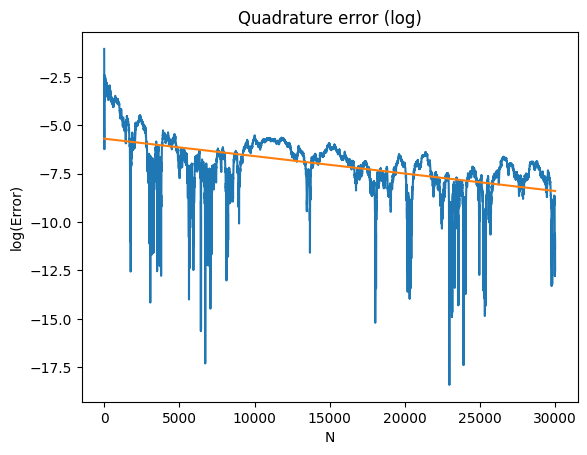

In [15]:
plt.plot(np.log(En_f))
plt.plot(approx_error, label='Interpolation')
plt.title('Quadrature error (log)')
plt.xlabel('N')
plt.ylabel('log(Error)')
plt.show()

The error seems not to be well modeled by $\log(error_n) =\alpha n + b$ as before. A model $\log(error_n) =\alpha \log(n) + b$ looks like a better model for the error deacy, as indicated below.

Of course, worth to remember, that due to the stochastic nature of the estimator, it is very commom to have "better" estimations at any given point, than the indicated by the regression.

In [16]:
model = LinearRegression().fit(np.log(np.linspace(1,len(En_f),len(En_f))).reshape((-1, 1)), np.log(En_f))
approx_error = model.intercept_ + np.log(np.linspace(1,len(En_f),len(En_f))) * model.coef_

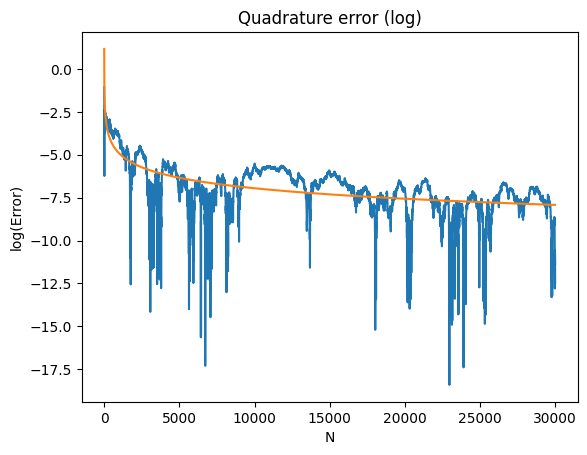

In [17]:
plt.plot(np.log(En_f))
plt.plot(approx_error, label='Interpolation')
plt.title('Quadrature error (log)')
plt.xlabel('N')
#plt.xscale('log')
plt.ylabel('log(Error)')
plt.show()

### Question 2.3

In [18]:
def mcmc_grw_one_au(density_func, n_variates, variance, step):

  x_j = 0
  total_variates = 0
  variates = []
  alphas = []
  accept = 0
  accepts = []
  normals = np.random.normal(0,1, 100*n_variates)
  uniforms = np.random.uniform(0,1, 100*n_variates)
  ln_uniforms = np.log(uniforms)
  std = step*np.sqrt(variance)
  i = 0

  def alpha_func(x,x_, density_func):
    return np.minimum(0, (np.log(density_func(x_)) + np.log(scipy.stats.norm.pdf(x_,x,std))) - (np.log(density_func(x))+np.log(scipy.stats.norm.pdf(x,x_,std))))

  #def alpha_func(x,x_, density_func):
   # return min(1, (density_func(x_)*scipy.stats.norm.pdf(x_,x,std))/(density_func(x)*scipy.stats.norm.pdf(x,x_,std)))


  while total_variates < n_variates:

    x_k = normals[i]*std + x_j
    alpha = alpha_func(x_j, x_k, density_func)
    alphas += np.exp(alpha),
    #alphas += alpha,


    #if uniforms[i] <= alpha:
    if ln_uniforms[i] <= alpha:
      variates += x_k,
      x_j = x_k
      accept += 1

    else:
      variates += x_j,

    total_variates +=1
    accepts += accept/(i+1),

    i += 1

  return variates, alphas, accepts

In [19]:
rnd, alphas, acc = mcmc_grw_one_au(rho_one, 5000, 1, 0.5)

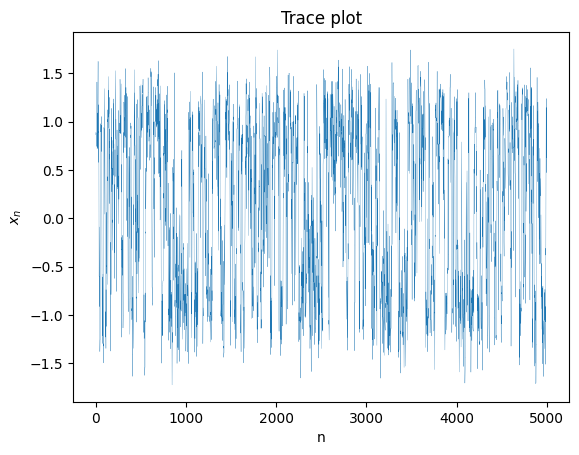

In [20]:
plt.plot(rnd,linewidth=.2)

plt.xlabel('n')
plt.ylabel(r'$x_n$')
plt.title('Trace plot')

plt.show()

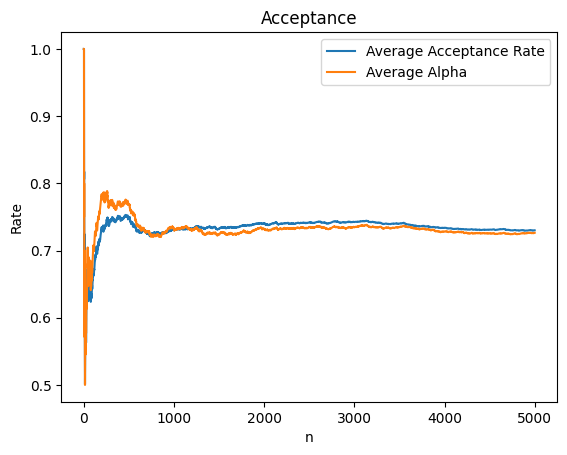

In [21]:


ma_alpha = [sum(alphas[:i+1])/(i+1) for i in range(len(alphas)-1)]
plt.plot(ma_alpha, label="Average Acceptance Rate")
plt.plot(acc, label="Average Alpha")
plt.title('Acceptance')
plt.xlabel('n')
plt.ylabel('Rate')
plt.legend()
plt.show()

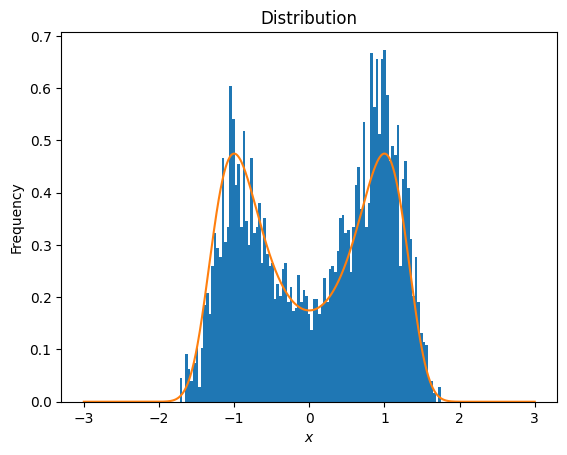

In [22]:
x = np.linspace(-3,3, 1000)
normalize, _ = scipy.integrate.fixed_quad(rho_one,-5,5, n=20)
rho = rho_one(x)/normalize
plt.title('Distribution')
plt.xlabel(r'$x$')
plt.ylabel('Frequency')
plt.hist(rnd, density=True, bins=100)
plt.plot(x, rho)
plt.show()

In [23]:
def mcmc_grw_one_au2(density_func, n_variates, variance, step):

  x_j = 0
  total_variates = 0
  variates = []
  alphas = []
  accept = 0
  accepts = []
  normals = np.random.normal(0,1, 100*n_variates)
  uniforms = np.random.uniform(0,1, 100*n_variates)
  ln_uniforms = np.log(uniforms)
  std = step*np.sqrt(variance)
  i = 0

  #def alpha_func(x,x_, density_func):
   # return np.minimum(0, (np.log(density_func(x_)) + np.log(scipy.stats.norm.pdf(x_,x,std))) - (np.log(density_func(x))+np.log(scipy.stats.norm.pdf(x,x_,std))))

  def alpha_func(x,x_, density_func):
    return min(1, (density_func(x_)*scipy.stats.norm.pdf(x_,x,std))/(density_func(x)*scipy.stats.norm.pdf(x,x_,std)))


  while total_variates < n_variates:

    x_k = normals[i]*std + x_j
    alpha = alpha_func(x_j, x_k, density_func)
    #alphas += np.exp(alpha),
    alphas += alpha,


    if uniforms[i] <= alpha:
    #if ln_uniforms[i] <= alpha:
      variates += x_k,
      x_j = x_k
      accepts += 1,

    else:
      variates += x_j,
      accepts += 0,

    total_variates +=1

    if i%100 == 0:
      rate = sum(accepts[i-100: i])/100
      if rate > 0.27:
        step *= 2
      elif rate < 0.19:
        step /= 2

      std = step*np.sqrt(variance)

    i += 1

  return variates, alphas, accepts

In [24]:
rnd, alphas, acc = mcmc_grw_one_au2(rho_one, 20000, 1, 1)

In [25]:
ma_alpha = []

for i in range(len(alphas)):
  a = alphas[i]
  if i == 0:
    ma_alpha += a,
  else:
    ma_alpha += ((i/(i+1)) * ma_alpha[-1] + (1/(i+1))*a),

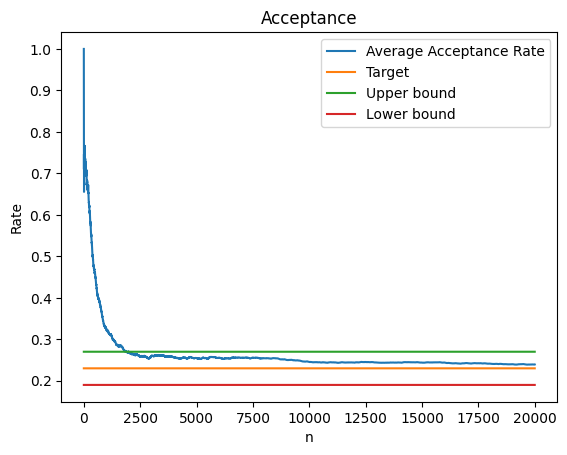

In [26]:
plt.plot(ma_alpha, label="Average Acceptance Rate")
plt.plot([0.23]*len(ma_alpha), label="Target")
plt.plot([0.27]*len(ma_alpha), label="Upper bound")
plt.plot([0.19]*len(ma_alpha), label="Lower bound")
plt.title('Acceptance')
plt.xlabel('n')
plt.ylabel('Rate')
plt.legend()
plt.show()

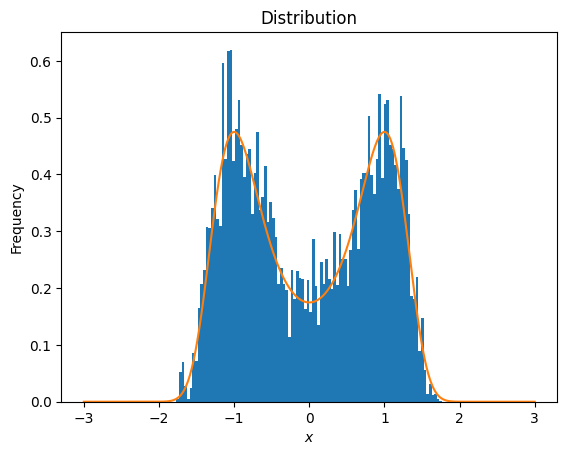

In [27]:
x = np.linspace(-3,3, 1000)
normalize, _ = scipy.integrate.fixed_quad(rho_one,-5,5, n=20)
plt.title('Distribution')
plt.xlabel(r'$x$')
plt.ylabel('Frequency')
rho = rho_one(x)/normalize
plt.hist(rnd, density=True, bins=100)
plt.plot(x, rho)
plt.show()

## N = 2

#### $\rho(x) \propto exp(-1(x_1^2 -1)^2 + 50(x_2 - x_1^2)^2)$

One important thing to notice about this density is that it is notoriously instable and hard to evaluate. Using off-the-shelf often lead to Warning meesanges or complete different values depending on the domain and number of nodes choose.

### Exercise 2.1

In [28]:
Normalized = True

In [29]:
### Define our basic functions

def rho_two(x1,x2): # Density for n=2
  def rho(x1,x2):
    return np.exp(-((x1-1)**2 + 50*((x2-(x1**2))**2)))
  if Normalized:
    return rho(x1,x2)/dblquad(rho, -np.infty, np.infty, lambda x: -np.infty, lambda x: np.infty)[0]
  else:
    return rho(x1,x2)

def func2(x1, x2): # f
  #return np.cos(np.sqrt(x1**2 + x2**2))
  return np.cos(np.linalg.norm([[x1,x2]],axis=1))

def dQ2(x1,x2): # A bit of abuse of notation. f(x1,x2)rho(x1,x2).
  return func2(x1,x2)*rho_two(x1,x2)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


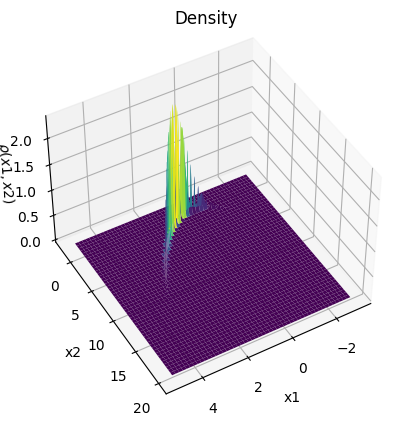

In [30]:
### Plot the density \rho(x1, x2)

from mpl_toolkits.mplot3d import Axes3D


def plot_rho(angle1, angle2):
  x1 = np.linspace(-3,5, 1000)
  x2 = np.linspace(-2,20, 1000)
  x1, x2 = np.meshgrid(x1,x2)

  rho = rho_two(x1,x2)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(x1, x2, rho, cmap='viridis')
  ax.view_init(angle1, angle2)

  ax.set_xlabel('x1')
  ax.set_ylabel('x2')
  ax.set_zlabel(r'$\rho(x1,x2)$', labelpad=-1)
  ax.set_title('Density')

  plt.show()

plot_rho(45, 60)

The quadrature scheme *dblquad*, used in the normalization, have some randomness built-in the algorithm, which sometimes may throw an warning about the function hard convergence.

Text(0.5, 0.92, 'dQ(f)')

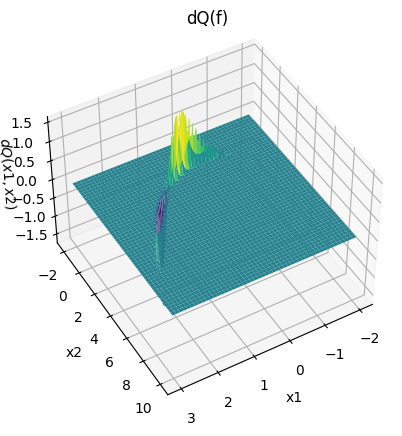

In [31]:
### Ploting the function to be integrated

x1 = np.linspace(-2,3, 2000)
x2 = np.linspace(-2,10, 2000)
x1, x2 = np.meshgrid(x1,x2)

dq = dQ2(x1,x2)[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, dq, cmap='viridis')
ax.view_init(45, 60)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel(r'$dQ(x1,x2)$', labelpad=-1)
ax.set_title('dQ(f)')

In [32]:
### Behaviour of off-the-shelf quadrature w.r.t N

N = np.linspace(1,200,200)
results = []


def integral_one(x1, n): # Inner Integral
  r, _ = scipy.integrate.fixed_quad(lambda x2: dQ2(x1,x2), -30, 30, n=n)
  return r

def integral_two(n): # Double integral
  r, _ = scipy.integrate.fixed_quad(lambda x1: integral_one(x1, n), -30, 30, n=n)
  return r


for n in N:
  results += integral_two(n=n),

errors = [np.abs(results[int(i-1)]-results[-1]) for i in N[:-1]]
ln_errors = [np.log(error) for error in errors]

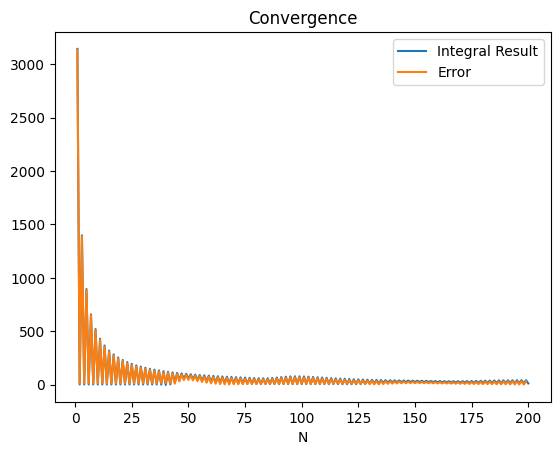

Integral result: 10.328655107568194


In [33]:
plt.plot(N, results, label='Integral Result')
plt.plot(N[:-1], errors, label='Error')
plt.legend()

plt.xlabel('N')
#plt.ylabel()
plt.title('Convergence')

plt.show()

print(f'Integral result: {results[-1]}')

Zoom in for N > 100

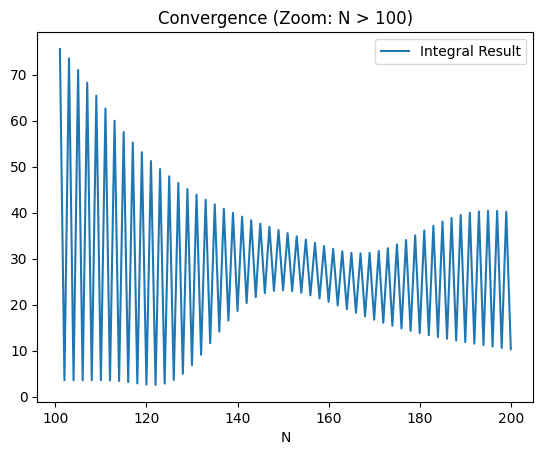

Integral result: 10.328655107568194


In [34]:
plt.plot(N[100:], results[100:], label='Integral Result')
#plt.plot(N[100:-1], errors[100:], label='Error')
plt.legend()

plt.xlabel('N')
#plt.ylabel()
plt.title('Convergence (Zoom: N > 100)')

plt.show()

print(f'Integral result: {results[-1]}')

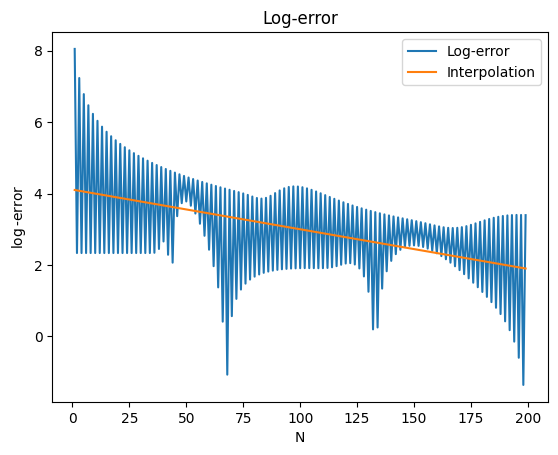

The approximate α is -0.011101481836026727


In [35]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(N[:-1].reshape((-1, 1)), ln_errors)
approx_error = model.intercept_ + N[:-1] * model.coef_

plt.plot(N[:-1], ln_errors, label='Log-error')
plt.plot(N[:-1], approx_error, label='Interpolation')

plt.legend()
plt.xlabel('N')
plt.ylabel(r'$\log$-error')
plt.title('Log-error')

plt.show()

alpha = '\\alpha'
print(f'The approximate α is {model.coef_[0]}')

The nature of convergence of this second integral is much less stable.

### Exercise 2.2

In [36]:
### For MCMC normalization does not matter, so it will be turned of to save resources

Normalized = False

In [37]:
def mcmc_grw_two(density_func, n_variates, covariance, step):

  x_j = [0,0]
  total_variates = 0
  variates = []
  normals = np.random.normal(0,1, [100*n_variates,2])
  uniforms = np.random.uniform(0,1, 100*n_variates)
  ln_uniforms = np.log(uniforms)
  L = np.linalg.cholesky(covariance)
  i = 0

  # Implementing the theoretical definition
  #def alpha_func(x,x_, density_func):
  #  return min(1, (density_func(x_)*scipy.stats.norm.pdf(x_,x,std))/(density_func(x)*scipy.stats.norm.pdf(x,x_,std)))

  # Implementing using log for computational reasons
  def alpha_func(x1, x2, x1_, x2_, density_func):
    rv1 = scipy.stats.multivariate_normal([x1,x2], step*step*covariance) # q(.| x)
    rv2 = scipy.stats.multivariate_normal([x1_,x2_], step*step*covariance) # q(.|x')
    return min(0, (np.log(density_func(x1_,x2_)) + np.log(rv1.pdf([x1_,x2_]))) - (np.log(density_func(x1,x2))+np.log(rv2.pdf([x1,x2]))))

  while total_variates < n_variates:

    x_k = np.dot(step*L, normals[i]) + x_j
    alpha = alpha_func(x_j[0], x_j[1], x_k[0], x_k[1], density_func)


    #if uniforms[i] <= alpha:
    if ln_uniforms[i] <= alpha:
      variates += x_k,
      x_j = x_k
    else:
      variates += x_j,

    total_variates +=1

    i += 1

  return variates

From the plot of the density and dQ above, we can see that the second coordinate is more stretched then the first. While the first coordinate in ρ is concentrated $\in [-2,4]$, the second coordinate stretches $\in [-1,20]$. This may suggest to have more volatility for x2 generation. In a first proposal, I will conjecturate a proportionality of the ratio of square roots of the range.

Also, the "nike logo" shape is more concetrated at the right of the zero, where the variables are positivly correleted. But we cannot neglet the left part where is negativly correlated. Therefore, assume a positive (but <1) correlation might prove beneficial, say 0.5.

In [38]:
### Generate a sample
rnd = mcmc_grw_two(rho_two, 30000, [[0.5,0.23],[0.23,0.93]], 1)

<ipython-input-37-b9854f9f0055>:20: RuntimeWarning: divide by zero encountered in log
  return min(0, (np.log(density_func(x1_,x2_)) + np.log(rv1.pdf([x1_,x2_]))) - (np.log(density_func(x1,x2))+np.log(rv2.pdf([x1,x2]))))


In [39]:
x1 = np.transpose(rnd)[0]
x2 = np.transpose(rnd)[1]

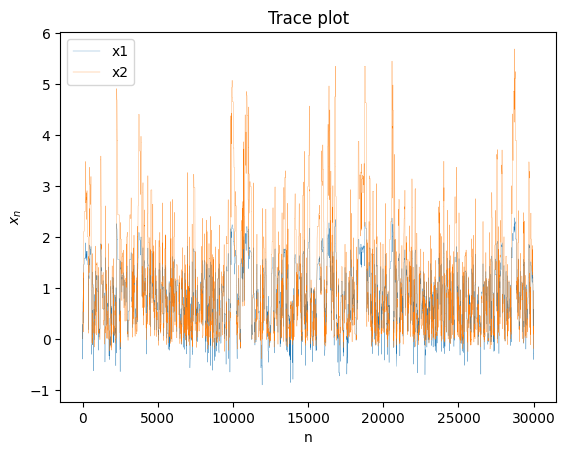

In [40]:
plt.plot(x1, linewidth=.2, label='x1')
plt.plot(x2, linewidth=.2, label='x2')
plt.xlabel('n')
plt.ylabel(r'$x_n$')
plt.title('Trace plot')
plt.legend()
plt.show()

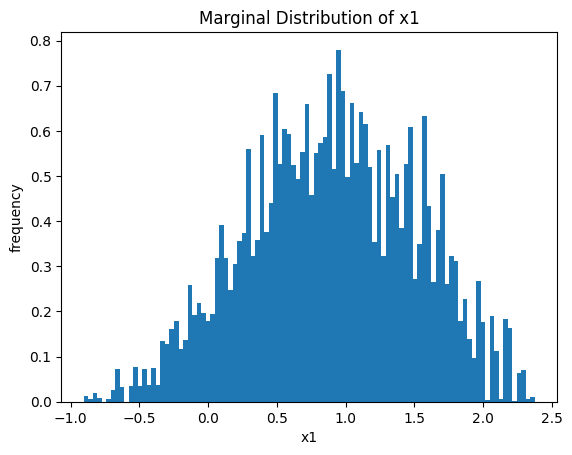

Analytical below


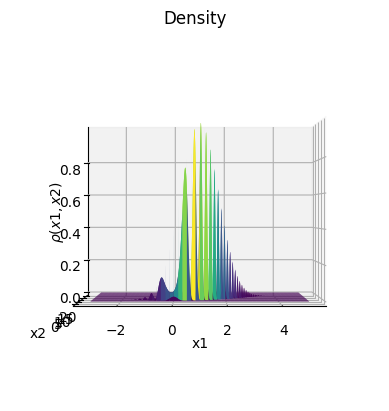

In [41]:
plt.hist(x1, density=True, bins=100)
plt.title('Marginal Distribution of x1')
plt.xlabel('x1')
plt.ylabel('frequency')
plt.show()
print('Analytical below')
plot_rho(0, 270)

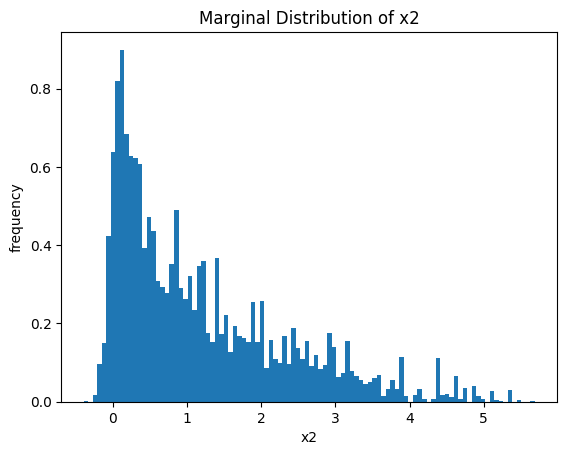

Analytical below


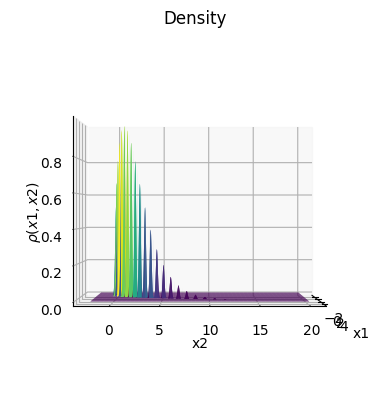

In [42]:
plt.hist(x2, density=True, bins=100)
plt.title('Marginal Distribution of x2')
plt.xlabel('x2')
plt.ylabel('frequency')
plt.show()
print('Analytical below')
plot_rho(0, 0)

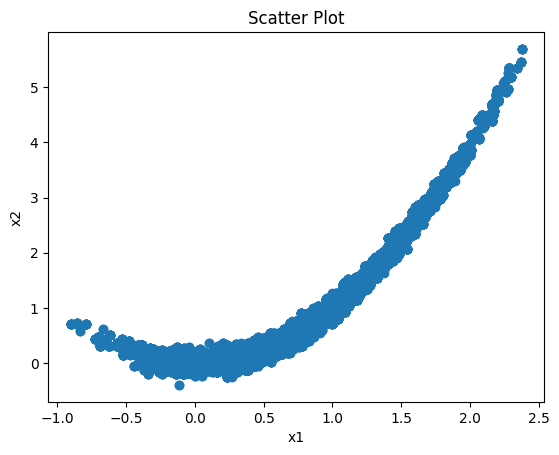

Analytical below


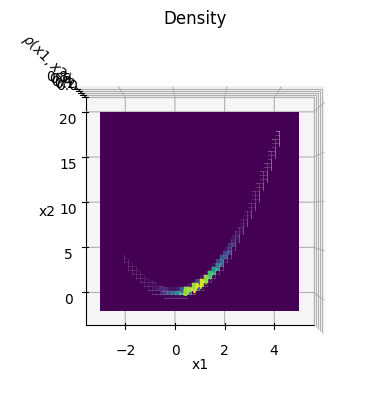

In [43]:
plt.title('Scatter Plot')
plt.scatter(x1,x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print('Analytical below')
plot_rho(90, 270)

In [44]:
En_f = []
En_f += 0,
f_avg = []



for i in range(len(rnd)):
  f = func2(x1[i], x2[i])
  if i == 0:
    f_avg += f,
  else:
    f_avg += ((i/(i+1)) * f_avg[-1] + (1/(i+1))*f),

En_f += np.abs(f_avg[:-1] - f_avg[-1]),

En_f = En_f[1:][0]

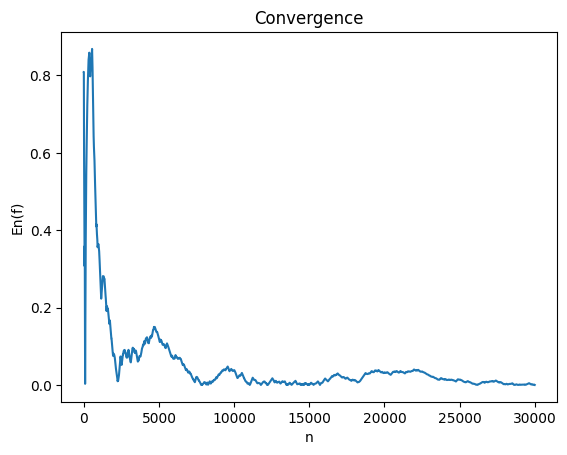

Last error: [1.30120899e-06]


In [45]:
plt.plot(En_f)
plt.title('Convergence')
plt.xlabel('n')
plt.ylabel('En(f)')
plt.show()
print(f'Last error: {En_f[-1]}')

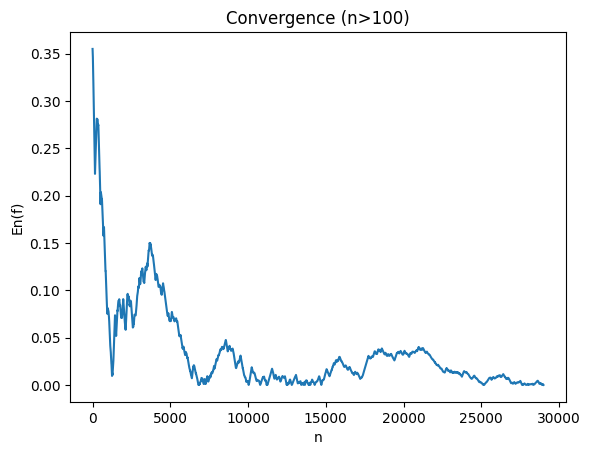

Last error: [1.30120899e-06]


In [46]:
plt.plot(En_f[1000:])
plt.title('Convergence (n>100)')
plt.xlabel('n')
plt.ylabel('En(f)')
plt.show()
print(f'Last error: {En_f[-1]}')

### Exercise 2.3

In [47]:
def mcmc_grw_two_au(density_func, n_variates, covariance, step):

  x_j = [0,0]
  total_variates = 0
  variates = []
  alphas = []
  accept = 0
  accepts = []
  normals = np.random.normal(0,1, [100*n_variates,2])
  uniforms = np.random.uniform(0,1, 100*n_variates)
  ln_uniforms = np.log(uniforms)
  L = np.linalg.cholesky(covariance)
  i = 0

  # Implementing the theoretical definition
  #def alpha_func(x,x_, density_func):
  #  return min(1, (density_func(x_)*scipy.stats.norm.pdf(x_,x,std))/(density_func(x)*scipy.stats.norm.pdf(x,x_,std)))

  # Implementing using log for computational reasons
  def alpha_func(x1, x2, x1_, x2_, density_func):
    rv1 = scipy.stats.multivariate_normal([x1,x2], step*step*covariance)
    rv2 = scipy.stats.multivariate_normal([x1_,x2_], step*step*covariance)
    return min(0, (np.log(density_func(x1_,x2_)) + np.log(rv1.pdf([x1_,x2_]))) - (np.log(density_func(x1,x2))+np.log(rv2.pdf([x1,x2]))))

  while total_variates < n_variates:

    x_k = np.dot(step*L, normals[i]) + x_j
    alpha = alpha_func(x_j[0], x_j[1], x_k[0], x_k[1], density_func)
    alphas += np.exp(alpha),


    #if uniforms[i] <= alpha:
    if ln_uniforms[i] <= alpha:
      variates += x_k,
      x_j = x_k
      accept += 1
    else:
      variates += x_j,

    total_variates +=1
    accepts += accept/(i+1),

    i += 1

  return variates, alphas, accepts

In [48]:
### Generate a sample
rnd, alphas, acc = mcmc_grw_two_au(rho_two, 30000, [[0.5,0.23],[0.23,0.93]], 1)

<ipython-input-47-5ca84e2d0783>:23: RuntimeWarning: divide by zero encountered in log
  return min(0, (np.log(density_func(x1_,x2_)) + np.log(rv1.pdf([x1_,x2_]))) - (np.log(density_func(x1,x2))+np.log(rv2.pdf([x1,x2]))))


In [49]:
ma_alpha = []

for i in range(len(alphas)):
  a = alphas[i]
  if i == 0:
    ma_alpha += f,
  else:
    ma_alpha += ((i/(i+1)) * ma_alpha[-1] + (1/(i+1))*a),

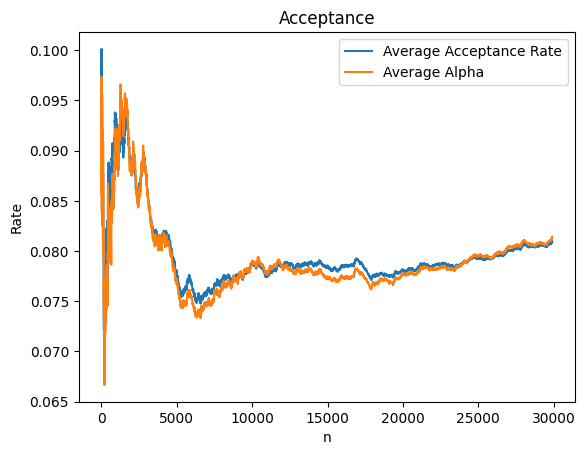

In [50]:
plt.title('Acceptance')
plt.xlabel('n')
plt.ylabel('Rate')
plt.plot(ma_alpha[100:], label="Average Acceptance Rate")
plt.plot(acc[100:], label="Average Alpha")
plt.legend()
plt.show()

In [51]:
def mcmc_grw_two_au2(density_func, n_variates, covariance, step):

  x_j = [0,0]
  total_variates = 0
  variates = []
  alphas = []
  accept = 0
  accepts = []
  normals = np.random.normal(0,1, [100*n_variates,2])
  uniforms = np.random.uniform(0,1, 100*n_variates)
  ln_uniforms = np.log(uniforms)
  L = np.linalg.cholesky(covariance)
  i = 0

  # Implementing the theoretical definition
  #def alpha_func(x,x_, density_func):
  #  return min(1, (density_func(x_)*scipy.stats.norm.pdf(x_,x,std))/(density_func(x)*scipy.stats.norm.pdf(x,x_,std)))

  # Implementing using log for computational reasons
  def alpha_func(x1, x2, x1_, x2_, density_func):
    rv1 = scipy.stats.multivariate_normal([x1,x2], np.dot(step*step,covariance))
    rv2 = scipy.stats.multivariate_normal([x1_,x2_], np.dot(step*step,covariance))
    return min(0, (np.log(density_func(x1_,x2_)) + np.log(rv1.pdf([x1_,x2_]))) - (np.log(density_func(x1,x2))+np.log(rv2.pdf([x1,x2]))))

  while total_variates < n_variates:
    #print(step)

    x_k = np.dot(step*L, normals[i]) + x_j
    alpha = alpha_func(x_j[0], x_j[1], x_k[0], x_k[1], density_func)
    alphas += np.exp(alpha),


    #if uniforms[i] <= alpha:
    if ln_uniforms[i] <= alpha:
      variates += x_k,
      x_j = x_k
      accepts += 1,
    else:
      variates += x_j,
      accepts += 0,

    total_variates +=1

    if i%100 == 0:
      rate = sum(accepts[i-100: i])/100
      if rate > 0.27:
        step *= 2
      elif rate < 0.19:
        step /= 2

        #print(step)

    i += 1

  return variates, alphas, accepts

In [52]:
### Generate a sample
rnd, alphas, acc = mcmc_grw_two_au2(rho_two, 30000, [[0.5,0.23],[0.23,0.93]],1)

<ipython-input-51-81deb928b894>:23: RuntimeWarning: divide by zero encountered in log
  return min(0, (np.log(density_func(x1_,x2_)) + np.log(rv1.pdf([x1_,x2_]))) - (np.log(density_func(x1,x2))+np.log(rv2.pdf([x1,x2]))))


In [53]:
ma_alpha = []

for i in range(len(alphas)):
  a = alphas[i]
  if i == 0:
    ma_alpha += a,
  else:
    ma_alpha += ((i/(i+1)) * ma_alpha[-1] + (1/(i+1))*a),

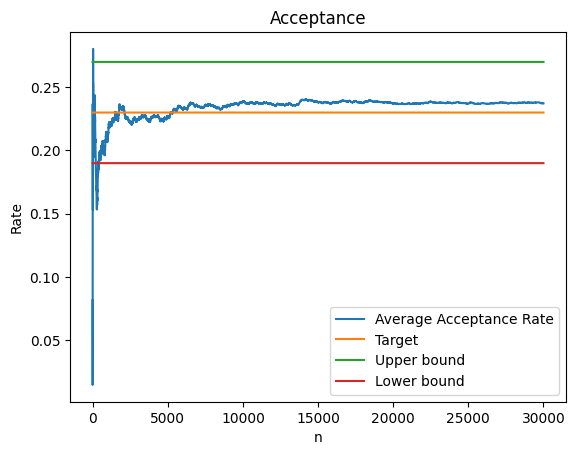

In [54]:
plt.title('Acceptance')
plt.xlabel('n')
plt.ylabel('Rate')
plt.plot(ma_alpha[:], label="Average Acceptance Rate")
plt.plot([0.23]*len(ma_alpha), label="Target")
plt.plot([0.27]*len(ma_alpha), label="Upper bound")
plt.plot([0.19]*len(ma_alpha), label="Lower bound")
##plt.plot(acc[100:], label="Average Alpha")
plt.legend()
plt.show()